# Using the saved data and a similarity threshold (δ=0.5) here we plot Figure 7.2

In [1]:
import pickle
import json
import requests 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from collections import defaultdict



In [2]:
ele2mp = {
    'Mo': 'mp-510536',
    'W': 'mp-19372',
    'Nb': 'mp-2533',
    'Ni': 'mp-35925', 
    'V': 'mp-19094',
    'Ir': 'mp-2723',
    'Ru': 'mp-825',
    'Cr': 'mp-19177',
    'Fe': 'mp-1205429', 
    'Mn': 'mp-19395', 
    'Co': 'mvc-14149',
    'Pb': 'mp-20725',
    'Sb': 'mp-230', 
    'Sn': 'mp-856',
    'Bi': 'mp-557993',
    'Ti': 'mp-390',
    'Ta': 'mp-510', 
    'In': 'mp-1181008',
    'Pt': 'mp-1077716',
    'Pd': 'mp-1018886',
    'Re': 'mp-12875',
    'Os': 'mp-996',
    'Ge': 'mp-2633',
    'Tc': 'mp-1205302',
    'Rh': 'mp-725',
    'Cu': 'mp-25378',
    'Te': 'mp-2125',
}


ele2col = {
    "Ti": "#808080",
    "V": "#ffcccb",
    "Cr": "w",
    "Mn": "purple",
    "Fe": "r",
    "Co": "b",
    "Cu": "#FFFF00",
    "Nb": "cyan",
    "Mo": "#FFA500",
    "W": "fuchsia",
    "Sb": "k",
    "Te": "y",
    "Ir": "b",
    "Ni": "#66FF00",
} 


In [3]:
# load fingerprint and energy data

binary_data = pickle.load(open("binary_oxide_data_form_ene_self_calc_fingerprints.p", "rb"))
unary_data = pickle.load(open("unary_oxide_data_self_calc.p", "rb"))

similarity_metric = 0.5

# save the bond length changes here.
element2structures = defaultdict(list)

for combination in binary_data:
    element1, element2 = combination.split("_")
    for binary_index, binary_fingerprint in enumerate(binary_data[combination]['fingerprints']):
        binary_structure = binary_data[combination]['structures'][binary_index]
        amount_ele1 = binary_structure.composition.as_dict()[element1]
        amount_ele2 = binary_structure.composition.as_dict()[element2]
        amount_o = binary_structure.composition.as_dict()["O"]
        o_proportion = amount_o/(amount_o+amount_ele2+amount_ele1)
        if o_proportion<(2/3):      # ONLY MO2 or higher stoichiometric O ratio
            continue
        for unary_element1_index, unary1_fingerprint in enumerate(unary_data[element1]['fingerprints']):
            for unary_element2_index, unary2_fingerprint in enumerate(unary_data[element2]['fingerprints']):
                unary_element_1_structure = unary_data[element1]['structures'][unary_element1_index]
                # only try to make a prediction if each compared oxide is 'similar' as defined by the similarity metric
                difference_1 = np.linalg.norm(binary_fingerprint - unary1_fingerprint)
                difference_2 = np.linalg.norm(binary_fingerprint - unary2_fingerprint)
                difference_3 = np.linalg.norm(unary1_fingerprint - unary2_fingerprint)
                if difference_1<similarity_metric and difference_2<similarity_metric and difference_3<similarity_metric:                    
                    ratio = amount_ele1/(amount_ele1+amount_ele2)

                    # grabs the energy at V=1.6
                    stability_ele1 = unary_data[element1]['energies'][unary_element1_index][6]
                    stability_ele2 = unary_data[element2]['energies'][unary_element2_index][6]
                    
                    # grabs the formtion energy
                    stability_ele1 = unary_data[element1]['formation_energies'][unary_element1_index]
                    stability_ele2 = unary_data[element2]['formation_energies'][unary_element2_index]
                    
                    
                    pred = ratio*stability_ele1 + (1-ratio)*stability_ele2
                    true_stability = binary_data[combination]['energies'][binary_index][0][6]
                    
                    true_stability = binary_data[combination]['formation_energies'][binary_index]
                    
                    binary_struct = binary_data[combination]['structures'][binary_index]
                    unary_struct1 = unary_data[element1]['structures'][unary_element1_index]
                    unary_struct2 = unary_data[element2]['structures'][unary_element2_index]
                    binary_id = binary_data[combination]['mp_ids'][binary_index]
                    unary_id1 = unary_data[element1]['mp_ids'][unary_element1_index]
                    unary_id2 = unary_data[element2]['mp_ids'][unary_element2_index]
                    # we add to a list of binaries and seen unaries in a given
                    # combination so that we don't recheck oxidation state changes
                    element2structures[element1].append((binary_struct, 
                                                             unary_struct1,
                                                             unary_struct2,
                                                             true_stability-pred,pred, true_stability,
                                                             ratio,
                                                            binary_id, unary_id1, unary_id2, 
                                                             difference_1, difference_2, difference_3,
                                                            o_proportion))
                    element2structures[element2].append((binary_struct, 
                                                             unary_struct2,
                                                             unary_struct1,
                                                             true_stability-pred,pred,true_stability,
                                                             1-ratio,
                                                            binary_id, unary_id2, unary_id1,
                                                            difference_2, difference_1, difference_3,
                                                            o_proportion))
 



In [4]:
ele2bond_deviation = defaultdict(list)
bond_deviation = []
eles2consider = ['Fe', 'Mn', 'Co', 'Cr',]
for ele in eles2consider:
    for info in element2structures[ele]:
        for idx, site in enumerate(info[2]):
            if str(site.specie)!="O":
                other_ele = str(site.specie)
            
        differenes = info[-4:-1]
        if max(differenes)>0.5:
            continue
        binary_struct = info[0]
        unary_struct_1 = info[1]
        unary_struct_2 = info[2]
        binary_nn_distances_1 = []
        binary_nn_distances_2 = []

        unary_nn_distances_1 = []
        unary_nn_distances_2 = []
        for idx, site in enumerate(binary_struct):
            if ele==str(site.specie):
                # for a given element, note its neighbours within 2 A radius
                nn_info = binary_struct.get_neighbors(site, 2.4)
                # find nn distances
                for nn in nn_info:
                    binary_nn_distances_1.append(nn.nn_distance)
            elif other_ele==str(site.specie):
                # for a given element, note its neighbours within 2 A radius
                nn_info = binary_struct.get_neighbors(site, 2.4)
                # find nn distances
                for nn in nn_info:
                    binary_nn_distances_2.append(nn.nn_distance)
                    
        for idx, site in enumerate(unary_struct_1):
            if ele==str(site.specie):
                # for a given element, note its neighbours within 2 A radius
                nn_info = unary_struct_1.get_neighbors(site, 2.4)
                # find nn distances
                for nn in nn_info:
                    unary_nn_distances_1.append(nn.nn_distance)
        for idx, site in enumerate(unary_struct_2):
            if other_ele==str(site.specie):
                # for a given element, note its neighbours within 2 A radius
                nn_info = unary_struct_2.get_neighbors(site, 2.4)
                # find nn distances
                for nn in nn_info:
                    unary_nn_distances_2.append(nn.nn_distance)
        bond_length_shift_1 = np.mean(unary_nn_distances_1)-np.mean(binary_nn_distances_1)
        bond_length_shift_2 = np.mean(unary_nn_distances_2)-np.mean(binary_nn_distances_2)
        bond_deviation.append((bond_length_shift_1, bond_length_shift_2,
                                   ele, other_ele, # elements
                                   info[6], 1-info[6],#ratio in binary
                                   info[3] # difference from weighted sum
                                  ) 
                                 )
        ele2bond_deviation[ele].append((bond_length_shift_1, bond_length_shift_2,
                                   ele, other_ele, # elements
                                   info[6], 1-info[6],#ratio in binary
                                   info[-7:-4],info[3] # difference from weighted sum
                                  ))



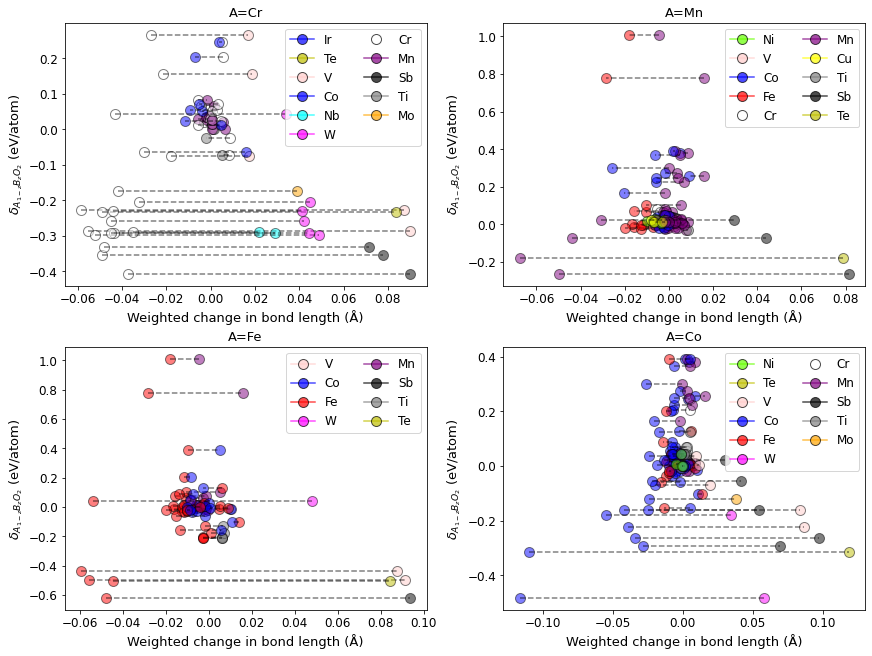

<Figure size 648x504 with 0 Axes>

<Figure size 648x504 with 0 Axes>

<Figure size 648x504 with 0 Axes>

<Figure size 648x504 with 0 Axes>

In [5]:
ele2position = {
    "Cr": [0,0],
    "Mn": [0,1],
    "Fe": [1,0],
    "Co": [1,1]
}
eles2consider = ['Fe', 'Mn', 'Co', 'Cr',]

fig = plt.figure(constrained_layout=True, figsize=(12, 9))

ax_array = fig.subplots(2, 2, squeeze=False)
for ele in eles2consider:
    relevant_eles = set()
    plt.figure(figsize=(9,7))
    seen_comparators = []

    for data in ele2bond_deviation[ele]:
        if str(data[3]) not in ele2col.keys() or str(data[2]) not in ele2col.keys():# or str(data[2])=='Sn' or str(data[2])=='Bi' or str(data[3])=='Sn' or str(data[3])=='Bi' or str(data[2])=='Cu' or str(data[3])=='Cu':# or str(data[2])=='Sn' or str(data[2])=='Bi':
            continue
        if data[-2][0] in seen_comparators:
            continue
        # one of the elements must match
        if data[2]!=ele and data[3]!=ele:#  or ("V"!=data[2] and "V"!=data[3]):
            continue
        relevant_eles.add(data[2])
        relevant_eles.add(data[3])
        x1 = data[0]*data[4]
        x2 = data[1]*data[5]
        ax_array[ele2position[ele][0],ele2position[ele][1]].plot(x1, data[-1], 'o', alpha=0.5, markeredgecolor='k', label=str(data[2]), markersize=10, color=ele2col[str(data[2])])
        ax_array[ele2position[ele][0],ele2position[ele][1]].plot(x2, data[-1], 'o', alpha=0.5, markeredgecolor='k', label=str(data[3]), markersize=10, color=ele2col[str(data[3])])
        ax_array[ele2position[ele][0],ele2position[ele][1]].plot([x1, x2], [data[-1], data[-1]], 'k--', alpha=0.5)
        seen_comparators.append(data[-2][0])
        
    legend_elements = [Line2D([0], [0], marker='o', color=ele2col[element], label=element,
                          markersize=10, markeredgecolor='k', alpha=0.7) for element in relevant_eles]
    ax_array[ele2position[ele][0],ele2position[ele][1]].legend(handles=legend_elements, ncol=2, loc='upper right', fontsize=12)
    ax_array[ele2position[ele][0],ele2position[ele][1]].set_xlabel("Weighted change in bond length (Å)", fontsize=13)
    ax_array[ele2position[ele][0],ele2position[ele][1]].set_ylabel("$\delta_{A_{1-z}B_{z}O_{2}}$ (eV/atom)", fontsize=13)
    ax_array[ele2position[ele][0],ele2position[ele][1]].tick_params(labelsize=12)
    ax_array[ele2position[ele][0],ele2position[ele][1]].set_title("A={}".format(ele), fontsize=13)
plt.show()